# Explain DeepTraffic

In [1]:
# Wei Wang (ww8137@mail.ustc.edu.cn)
#
# This Source Code Form is subject to the terms of the Mozilla Public
# License, v. 2.0. If a copy of the MPL was not distributed with this file, You
# can obtain one at http://mozilla.org/MPL/2.0/.
# ==============================================================================

import os
import time
import numpy as np

# start tensorflow interactiveSession
import tensorflow.compat.v1 as tf  # load MNIST data

from sklearn.metrics import classification_report
from skexplain.utils import input_data


tf.compat.v1.disable_eager_execution()

DATA_DIR = "../res/dataset/DeepTraffic/2class/SessionAllLayers"

VALIDATION_DATA_DIR = "../res/dataset/DeepTraffic/validation/2class/SessionAllLayers"
VALIDATION_64_DATA_DIR = "../res/dataset/DeepTraffic/validation/2class-64/SessionAllLayers" # altered dataset byte 23 === 101
VALIDATION_128_DATA_DIR = "../res/dataset/DeepTraffic/validation/2class-128/SessionAllLayers" # altered dataset byte 23 === 101
VALIDATION_32_64_DATA_DIR = "../res/dataset/DeepTraffic/validation/2class-32-64/SessionAllLayers" # altered dataset byte 23 === 101
VALIDATION_43_47_49_DATA_DIR = "../res/dataset/DeepTraffic/validation/2class-43-47-49/SessionAllLayers" # altered dataset byte 23 === 101


CLASS_NUM = 2
TRAIN_ROUND = 20000


folder = os.path.split(DATA_DIR)[1]
dict_2class = {0: "Novpn", 1: "Vpn"}
dict_6class_novpn = {
    0: "Chat",
    1: "Email",
    2: "File",
    3: "P2p",
    4: "Streaming",
    5: "Voip",
}
dict_6class_vpn = {
    0: "Vpn_Chat",
    1: "Vpn_Email",
    2: "Vpn_File",
    3: "Vpn_P2p",
    4: "Vpn_Streaming",
    5: "Vpn_Voip",
}
dict_12class = {
    0: "Chat",
    1: "Email",
    2: "File",
    3: "P2p",
    4: "Streaming",
    5: "Voip",
    6: "Vpn_Chat",
    7: "Vpn_Email",
    8: "Vpn_File",
    9: "Vpn_P2p",
    10: "Vpn_Streaming",
    11: "Vpn_Voip",
}




def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return -1


# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")


# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 1, 3, 1], strides=[1, 1, 3, 1], padding="SAME")


class DeepTraffic:
    def __init__(self):
        self.sess = tf.InteractiveSession()

        # Create the model
        # placeholder
        self.x = tf.placeholder("float", [None, 784])
        self.y_ = tf.placeholder("float", [None, CLASS_NUM])

        # first convolutinal layer
        self.w_conv1 = weight_variable([1, 25, 1, 32])
        self.b_conv1 = bias_variable([32])

        self.x_image = tf.reshape(self.x, [-1, 1, 784, 1])

        self.h_conv1 = tf.nn.relu(conv2d(self.x_image, self.w_conv1) + self.b_conv1)
        self.h_pool1 = max_pool_2x2(self.h_conv1)

        # second convolutional layer
        self.w_conv2 = weight_variable([1, 25, 32, 64])
        self.b_conv2 = bias_variable([64])

        self.h_conv2 = tf.nn.relu(conv2d(self.h_pool1, self.w_conv2) + self.b_conv2)
        self.h_pool2 = max_pool_2x2(self.h_conv2)

        # densely connected layer
        self.w_fc1 = weight_variable([1 * 88 * 64, 1024])
        self.b_fc1 = bias_variable([1024])

        self.h_pool2_flat = tf.reshape(self.h_pool2, [-1, 1 * 88 * 64])
        self.h_fc1 = tf.nn.relu(tf.matmul(self.h_pool2_flat, self.w_fc1) + self.b_fc1)

        # dropout
        self.keep_prob = tf.placeholder("float")
        self.h_fc1_drop = tf.nn.dropout(self.h_fc1, self.keep_prob)

        # readout layer
        self.w_fc2 = weight_variable([1024, CLASS_NUM])
        self.b_fc2 = bias_variable([CLASS_NUM])

        # From Site1997:
        # This would cause nan or 0 gradient if "tf.matmul(h_fc1_drop, w_fc2) + b_fc2" is all zero or nan,
        # so when the training iteration is big enough, all weights could suddenly became 0.
        # Use tf.nn.ax_cross_entropy_with_logits instead. It handles the extreme case safely.
        self.y_conv = tf.nn.softmax(tf.matmul(self.h_fc1_drop, self.w_fc2) + self.b_fc2)

        # y_conv = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

        # define var&op of training&testing
        self.actual_label = tf.argmax(self.y_, 1)
        self.label, self.idx, self.count = tf.unique_with_counts(self.actual_label)
        self.cross_entropy = -tf.reduce_sum(self.y_ * tf.log(self.y_conv))
        self.train_step = tf.train.GradientDescentOptimizer(1e-4).minimize(
            self.cross_entropy
        )
        self.predict_label = tf.argmax(self.y_conv, 1)
        self.label_p, self.dx_p, self.count_p = tf.unique_with_counts(
            self.predict_label
        )
        self.correct_prediction = tf.equal(self.predict_label, self.actual_label)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, "float"))
        self.correct_label = tf.boolean_mask(self.actual_label, self.correct_prediction)
        self.label_c, self.idx_c, self.count_c = tf.unique_with_counts(
            self.correct_label
        )

    def fit(self, dataset):
        # if model exists: restore it
        # else: train a new model and save it
        saver = tf.train.Saver()
        model_name = "model_" + str(CLASS_NUM) + "class_" + folder
        model = model_name + "/" + model_name + ".ckpt"
        print(model)
        i = 0
        if not os.path.exists(model + ".meta"):
            self.sess.run(tf.global_variables_initializer())
            if not os.path.exists(model_name):
                os.makedirs(model_name)

            for i in range(TRAIN_ROUND + 1):
                batch = dataset.next_batch(50)
                # batch = mnist_train.shuffle(1204).batch(50).repeat(TRAIN_ROUND + 1).prefetch(10)
                # for sample in tensorflow_datasets.as_numpy(batch):
                # batch_images, batch_labels = sample["image"].reshape(
                # [50, 784]), tensorflow_datasets.as_numpy(tf.one_hot(sample["label"], CLASS_NUM))

                if i % 100 == 0:
                    train_accuracy = self.accuracy.eval(
                        feed_dict={
                            self.x: batch[0],
                            self.y_: batch[1],
                            self.keep_prob: 1.0,
                        }
                    )
                    s = "step %d, train accuracy %g" % (i, train_accuracy)
                    print(s)
                    # if i%2000 == 0:
                    #     with open('out.txt','a') as f:
                    #         f.write(s + "\n")
                self.train_step.run(
                    feed_dict={self.x: batch[0], self.y_: batch[1], self.keep_prob: 0.5}
                )
                # i += 1

            save_path = saver.save(self.sess, model)
            print("Model saved in file:", save_path)
        else:
            saver.restore(self.sess, model)
            print("Model restored: " + model)

    def predict(self, X):
        params = [self.y_conv]
        y = self.sess.run(
            params,
            {self.x: X, self.keep_prob: 1.0},
        )

        return np.array([np.argmax(test) for test in y[0]])

    def predict_proba(self, X):
        params = [self.y_conv]
        y = self.sess.run(
            params,
            {self.x: X, self.keep_prob: 1.0},
        )
        
        return np.array(y[0])



In [2]:

print("DeepTraffic Script Start")
dataset = input_data.read_data_sets(DATA_DIR, one_hot=True, num_classes=CLASS_NUM)

dict = {}
# evaluate the model
if CLASS_NUM == 12:
    dict = dict_12class
elif CLASS_NUM == 2:
    dict = dict_2class
elif CLASS_NUM == 6:
    if folder.startswith("Novpn"):
        dict = dict_6class_novpn
    elif folder.startswith("Vpn"):
        dict = dict_6class_vpn


class_names = dict.values()  
print("Initializing DeepTraffic")
deep_traffic = DeepTraffic()
deep_traffic.fit(dataset.train)
X_train = dataset.train.images
y_train = np.array([np.argmax(i) for i in dataset.train.labels])
X_test = dataset.test.images
y_test = np.array([np.argmax(i) for i in dataset.test.labels])
y_pred = deep_traffic.predict(X_test)

print(X_train.shape)
print(X_test.shape)

print(
    "{}".format(
        classification_report(y_test, y_pred, digits=3, target_names=class_names)
    )
)

DeepTraffic Script Start
Extracting ../res/dataset/DeepTraffic/2class/SessionAllLayers/train-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/2class/SessionAllLayers/train-labels-idx1-ubyte.gz
Extracting ../res/dataset/DeepTraffic/2class/SessionAllLayers/t10k-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/2class/SessionAllLayers/t10k-labels-idx1-ubyte.gz
Initializing DeepTraffic
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
model_2class_SessionAllLayers/model_2class_SessionAllLayers.ckpt
INFO:tensorflow:Restoring parameters from model_2class_SessionAllLayers/model_2class_SessionAllLayers.ckpt
Model restored: model_2class_SessionAllLayers/model_2class_SessionAllLayers.ckpt
(30501, 784)
(3945, 784)
              precision    recall  f1-score   support

       Novpn      1.000     1.000     1.000      2692
         Vpn      0.999     0.999     0.999      1253

    accuracy                          0

In [5]:

print("DeepTraffic Validation Start")
validation_dataset = input_data.read_data_sets(VALIDATION_DATA_DIR, one_hot=True, num_classes=CLASS_NUM)

X_validation = validation_dataset.test.images
y_validation = np.array([np.argmax(i) for i in validation_dataset.test.labels])
y_val_pred = deep_traffic.predict(X_validation)

print(
    "{}".format(
        classification_report(y_validation, y_val_pred, digits=3, target_names=class_names)
    )
)

DeepTraffic Validation Start
Extracting ../res/dataset/DeepTraffic/validation/2class/SessionAllLayers/train-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class/SessionAllLayers/train-labels-idx1-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class/SessionAllLayers/t10k-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class/SessionAllLayers/t10k-labels-idx1-ubyte.gz
              precision    recall  f1-score   support

       Novpn      0.927     1.000     0.962      1859
         Vpn      1.000     0.902     0.948      1497

    accuracy                          0.956      3356
   macro avg      0.963     0.951     0.955      3356
weighted avg      0.959     0.956     0.956      3356



In [6]:

print("DeepTraffic Validation Start")
alt_64_dataset = input_data.read_data_sets(VALIDATION_64_DATA_DIR, one_hot=True, num_classes=CLASS_NUM)

X_validation_alt_64 = alt_64_dataset.test.images
y_validation_alt_64 = np.array([np.argmax(i) for i in alt_64_dataset.test.labels])
y_val_alt_64_pred = deep_traffic.predict(X_validation_alt_64)

print(
    "{}".format(
        classification_report(y_validation_alt_64, y_val_alt_64_pred, digits=3, target_names=class_names)
    )
)

DeepTraffic Validation Start
Extracting ../res/dataset/DeepTraffic/validation/2class-64/SessionAllLayers/train-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-64/SessionAllLayers/train-labels-idx1-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-64/SessionAllLayers/t10k-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-64/SessionAllLayers/t10k-labels-idx1-ubyte.gz
              precision    recall  f1-score   support

       Novpn      0.695     1.000     0.820      1859
         Vpn      1.000     0.456     0.626      1497

    accuracy                          0.757      3356
   macro avg      0.848     0.728     0.723      3356
weighted avg      0.831     0.757     0.734      3356



In [7]:

print("DeepTraffic Validation Start")
alt_128_dataset = input_data.read_data_sets(VALIDATION_128_DATA_DIR, one_hot=True, num_classes=CLASS_NUM)

X_validation_alt_128 = alt_128_dataset.test.images
y_validation_alt_128 = np.array([np.argmax(i) for i in alt_128_dataset.test.labels])
y_val_alt_128_pred = deep_traffic.predict(X_validation_alt_128)

print(
    "{}".format(
        classification_report(y_validation_alt_128, y_val_alt_128_pred, digits=3, target_names=class_names)
    )
)

DeepTraffic Validation Start
Extracting ../res/dataset/DeepTraffic/validation/2class-128/SessionAllLayers/train-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-128/SessionAllLayers/train-labels-idx1-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-128/SessionAllLayers/t10k-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-128/SessionAllLayers/t10k-labels-idx1-ubyte.gz
              precision    recall  f1-score   support

       Novpn      0.555     1.000     0.714      1859
         Vpn      1.000     0.003     0.007      1497

    accuracy                          0.555      3356
   macro avg      0.777     0.502     0.360      3356
weighted avg      0.753     0.555     0.398      3356



In [4]:

print("DeepTraffic Validation Start")
alt_32_64_dataset = input_data.read_data_sets(VALIDATION_32_64_DATA_DIR, one_hot=True, num_classes=CLASS_NUM)

X_validation_alt_32_64 = alt_32_64_dataset.test.images
y_validation_alt_32_64 = np.array([np.argmax(i) for i in alt_32_64_dataset.test.labels])
y_val_alt_32_64_pred = deep_traffic.predict(X_validation_alt_32_64)

print(
    "{}".format(
        classification_report(y_validation_alt_32_64, y_val_alt_32_64_pred, digits=3, target_names=class_names)
    )
)

DeepTraffic Validation Start
Extracting ../res/dataset/DeepTraffic/validation/2class-32-64/SessionAllLayers/train-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-32-64/SessionAllLayers/train-labels-idx1-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-32-64/SessionAllLayers/t10k-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-32-64/SessionAllLayers/t10k-labels-idx1-ubyte.gz
              precision    recall  f1-score   support

       Novpn      0.799     1.000     0.888      1859
         Vpn      1.000     0.688     0.815      1497

    accuracy                          0.861      3356
   macro avg      0.900     0.844     0.852      3356
weighted avg      0.889     0.861     0.856      3356



In [10]:

print("DeepTraffic Validation Start")
alt_43_47_49_dataset = input_data.read_data_sets(VALIDATION_43_47_49_DATA_DIR, one_hot=True, num_classes=CLASS_NUM)

X_validation_alt_43_47_49 = alt_43_47_49_dataset.test.images
y_validation_alt_43_47_49 = np.array([np.argmax(i) for i in alt_43_47_49_dataset.test.labels])
y_val_alt_43_47_49_pred = deep_traffic.predict(X_validation_alt_43_47_49)

print(
    "{}".format(
        classification_report(y_validation_alt_43_47_49, y_val_alt_43_47_49_pred, digits=3, target_names=class_names)
    )
)

DeepTraffic Validation Start
Extracting ../res/dataset/DeepTraffic/validation/2class-43-47-49/SessionAllLayers/train-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-43-47-49/SessionAllLayers/train-labels-idx1-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-43-47-49/SessionAllLayers/t10k-images-idx3-ubyte.gz
Extracting ../res/dataset/DeepTraffic/validation/2class-43-47-49/SessionAllLayers/t10k-labels-idx1-ubyte.gz
              precision    recall  f1-score   support

       Novpn      0.926     1.000     0.961      1859
         Vpn      1.000     0.900     0.948      1497

    accuracy                          0.956      3356
   macro avg      0.963     0.950     0.955      3356
weighted avg      0.959     0.956     0.955      3356



In [12]:
from interpret import show
from interpret.blackbox import LimeTabular

# Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=deep_traffic.predict_proba, data=X_train, random_state=1)

# Pick the instances to explain, optionally pass in labels if you have them
# test_cases = [int(n) for n in y_test]

lime_local = lime.explain_local([X_test[5]], [y_test[5]])
print(y_test[5])

show(lime_local)


1


<!-- http://127.0.0.1:7001/5733203304/ -->

In [18]:

lime_local = lime.explain_local([X_test[0]], [y_test[0]])
print(y_test[0])

show(lime_local)

0


<!-- http://127.0.0.1:7001/5733201960/ -->

In [9]:
deep_traffic.sess.close()

In [3]:
import graphviz
import rootpath

from skexplain.imitation import ClassificationDagger
from skexplain.utils import log

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, f1_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import LinearSVC


logger = log.Logger("{}/res/log/{}/dagger_test.log".format(rootpath.detect(), 'DeepTraffic'))

logger.log("Using Classification Dagger algorithm...")
dagger = ClassificationDagger(expert=deep_traffic, logger=logger)

dagger.fit(X_train, y_train, max_iter=50, max_leaf_nodes=None,
           num_samples=5000, ccp_alpha=0.0002)

logger.log("#" * 10, "Explanation validation", "#" * 10)
(_, max_reward, _) = dagger.explain()

students = dagger.get_students()
all_explanations = [student for student in students if student[1] == max_reward]

for (dt, reward, idx) in all_explanations:
    logger.log("Model explanation {} local fidelity: {}".format(idx, reward))
    dt_y_pred = dt.predict(X_test)

    logger.log("Model explanation classification report:")
    logger.log("\n{}".format(classification_report(y_test, dt_y_pred, digits=3)))

    logger.log("Model explanation global fidelity report:")
    logger.log("\n{}".format(classification_report(y_pred, dt_y_pred, digits=3)))
    
    dot_data = tree.export_graphviz(dt,
                                class_names=list(class_names),
                                filled=True,
                                rounded=True,
                                special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render("{}/res/img/{}/{}/dt_{}_{}".format(rootpath.detect(),
                                                        "DeepTraffic",
                                                        "dagger",
                                                        dt.get_n_leaves(), 
                                                        idx))

2021-06-29 17:53:16,954 - INFO - Using Classification Dagger algorithm...
2021-06-29 17:53:48,681 - INFO - ########## Explanation validation ##########
2021-06-29 17:53:48,682 - INFO - Model explanation 0 local fidelity: 1.0
2021-06-29 17:53:48,685 - INFO - Model explanation classification report:
2021-06-29 17:53:48,694 - INFO - 
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      2692
           1      1.000     0.999     1.000      1253

    accuracy                          1.000      3945
   macro avg      1.000     1.000     1.000      3945
weighted avg      1.000     1.000     1.000      3945

2021-06-29 17:53:48,695 - INFO - Model explanation global fidelity report:
2021-06-29 17:53:48,702 - INFO - 
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      2692
           1      1.000     0.999     1.000      1253

    accuracy                          1.000      3945
   macro avg 

2021-06-29 17:53:51,606 - INFO - Model explanation global fidelity report:
2021-06-29 17:53:51,614 - INFO - 
              precision    recall  f1-score   support

           0      1.000     0.999     0.999      2692
           1      0.997     0.999     0.998      1253

    accuracy                          0.999      3945
   macro avg      0.998     0.999     0.999      3945
weighted avg      0.999     0.999     0.999      3945

2021-06-29 17:53:51,949 - INFO - Model explanation 19 local fidelity: 1.0
2021-06-29 17:53:51,955 - INFO - Model explanation classification report:
2021-06-29 17:53:51,963 - INFO - 
              precision    recall  f1-score   support

           0      1.000     0.999     1.000      2692
           1      0.998     1.000     0.999      1253

    accuracy                          0.999      3945
   macro avg      0.999     1.000     0.999      3945
weighted avg      0.999     0.999     0.999      3945

2021-06-29 17:53:51,964 - INFO - Model explanation glob

2021-06-29 17:53:54,814 - INFO - Model explanation global fidelity report:
2021-06-29 17:53:54,822 - INFO - 
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      2692
           1      1.000     0.999     1.000      1253

    accuracy                          1.000      3945
   macro avg      1.000     1.000     1.000      3945
weighted avg      1.000     1.000     1.000      3945

2021-06-29 17:53:55,157 - INFO - Model explanation 44 local fidelity: 1.0
2021-06-29 17:53:55,163 - INFO - Model explanation classification report:
2021-06-29 17:53:55,170 - INFO - 
              precision    recall  f1-score   support

           0      1.000     0.999     0.999      2692
           1      0.998     1.000     0.999      1253

    accuracy                          0.999      3945
   macro avg      0.999     0.999     0.999      3945
weighted avg      0.999     0.999     0.999      3945

2021-06-29 17:53:55,171 - INFO - Model explanation glob

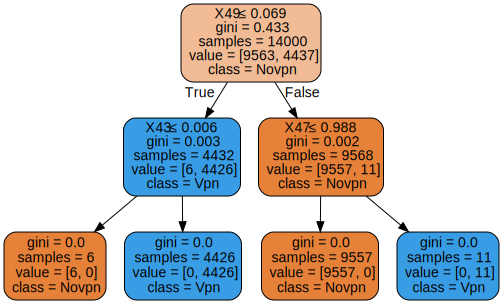

In [17]:
from IPython.display import display

dot_data = tree.export_graphviz(dt,
                                class_names=list(class_names),
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("{}/res/img/{}/{}/dt_{}".format(rootpath.detect(),
                                                    "DeepTraffic",
                                                    "dagger",
                                                    dt.get_n_leaves()))

display(graph)
